In [1]:
! pip install -q tensorflow numpy pandas scikit-learn mlxtend dataprep transformers
! cp drive/My\ Drive/Colab\ Notebooks/*.csv ./
! cp drive/My\ Drive/Colab\ Notebooks/*.pkl ./

     |████████████████████████████████| 112kB 7.2MB/s 
     |████████████████████████████████| 890kB 14.0MB/s 
     |████████████████████████████████| 2.2MB 35.2MB/s 
     |████████████████████████████████| 368kB 56.7MB/s 
     |████████████████████████████████| 71kB 6.6MB/s 
     |████████████████████████████████| 8.6MB 25.1MB/s 
     |████████████████████████████████| 829kB 47.9MB/s 
     |████████████████████████████████| 1.4MB 51.6MB/s 
     |████████████████████████████████| 61kB 5.5MB/s 
     |████████████████████████████████| 5.5MB 47.7MB/s 
     |████████████████████████████████| 1.2MB 54.8MB/s 
     |████████████████████████████████| 512kB 38.8MB/s 
     |████████████████████████████████| 3.0MB 56.2MB/s 
     |████████████████████████████████| 890kB 54.6MB/s 
     |████████████████████████████████| 1.1MB 44.8MB/s 
     |████████████████████████████████| 655kB 47.7MB/s 
     |████████████████████████████████| 92kB 7.8MB/s 
     |████████████████████████████████| 266kB 59.8MB/s 

In [2]:
def augment(training):
  training = np.repeat(training, 10, axis=0)
  temp = pickle.load(open('resnest_embeddings.pkl', 'rb'))
  for i in range(0, len(training), 10):
    for j in range(len(X)):
        if np.all(training[i][:1000] == X[j][:1000]):
          for k in range(1, 10):
            training[i+k] = np.concatenate([temp[j*10+k][:1000], training[i+k][1000:]])
          break
  return training

In [3]:
def ds_from_df(df, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('Meme')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [4]:
def create_map():
  temp = df[['Visual']].values
  counter = 0
  map = {}
  for i in temp:
    for j in i[0].split():
      if j.strip(',') not in map and j.strip(',') != '0':
        map[j.strip(',')] = counter
        counter += 1
  return map

In [5]:
def get_X(temp):
  res = []
  for i in range(0, len(temp), 10):
    res.append(temp[i])
  return np.array(res)

In [6]:
def ohe(map):
  one_hot_encode = []
  temp = df[['Visual']].values

  for i in temp:
    arr = list(np.zeros(len(map),dtype=int))
    for j in i[0].split():
      if j.strip(',') != '0':
        arr[map[j.strip(',')]] = 1
    one_hot_encode.append(arr)
  return np.array(one_hot_encode)

In [8]:
def build_model(input_shape=(None, 2889)):
  model = tf.keras.Sequential([tf.keras.layers.Dense(1024, 
                                                     name='dense_1',
                                                     activation=tf.keras.activations.relu),
                               tf.keras.layers.Dropout(rate=0.3),
                               tf.keras.layers.Dense(512, 
                                                     name='dense_2',
                                                     activation=tf.keras.activations.relu),
                               tf.keras.layers.Dense(512, 
                                                     name='dense_3',
                                                     activation=tf.keras.activations.relu),
                               tf.keras.layers.Dense(128, 
                                                     name='dense_4',
                                                     activation=tf.keras.activations.relu),
                               tf.keras.layers.Dense(64, 
                                                     name='dense_5',
                                                     activation=tf.keras.activations.relu),
                               tf.keras.layers.Dense(1, name='output',
                                                     activation=tf.keras.activations.sigmoid)])
  print(model.compute_output_shape(input_shape=input_shape))
  model.build(input_shape=input_shape)
  return model

In [9]:
import pandas as pd

df = pd.read_csv('dankmemes_task1_train.csv')
embedding = pd.read_csv('dankmemes_task1_train_embeddings.csv', header=None)

In [10]:
import numpy as np
import pickle

# X, y = get_X(pickle.load(open('resnest_embeddings.pkl', 'rb'))), df[['Meme']].values
X, y = np.array([embedding[1][i].split() for i in range(1600)]).astype(float), df[['Meme']].values

In [11]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

ssc = StandardScaler()
mms = MinMaxScaler()

In [12]:
import pickle
from datetime import date

temp = mms.fit_transform(np.array([(date(int(i[0].split('-')[0]), int(i[0].split('-')[1]), int(i[0].split('-')[2])) - date(2015, 1, 1)).days for i in df[['Date']].values.tolist()]).reshape(1600, 1))
print(temp.shape)
X = np.hstack((X, temp))
print(X.shape)

temp = ssc.fit_transform(df[['Engagement']].values)
print(temp.shape)
X = np.hstack((X, temp))
print(X.shape)

temp = ohe(create_map())
print(temp.shape)
X = np.hstack((X, temp))
print(X.shape)

temp = pickle.load(open('umberto_embeddings.pkl', 'rb'))
print(temp.shape)
X = np.hstack((X, temp))
print(X.shape)

(1600, 1)
(1600, 2049)
(1600, 1)
(1600, 2050)
(1600, 71)
(1600, 2121)
(1600, 768)
(1600, 2889)


In [21]:
buffer_size = 10000
batch_size = 32
num_epochs = 100

In [22]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
# X_train = augment(X_train)
# y_train = np.repeat(y_train, 10, axis=0)
print(X.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape)

ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
ds_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))

ds_train = ds_train.shuffle(buffer_size=buffer_size,
                            reshuffle_each_iteration=False)
ds_test = ds_test.batch(batch_size)
ds_train = ds_train.batch(batch_size)

(1600, 2889) (1280, 2889) (1280, 1) (320, 2889) (320, 1)


In [23]:
model = build_model(input_shape=(None, 2889))
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
model.summary()

(None, 1)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              2959360   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
output (Dense)               (None, 1)      

In [24]:
hist = model.fit(ds_train,
                 validation_data=ds_test,
                 epochs=num_epochs,
                 batch_size=batch_size,
                 use_multiprocessing=True,
                 callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)])

Epoch 1/100
40/40 [==============================] - 1s 24ms/step - loss: 0.6773 - binary_accuracy: 0.6016 - val_loss: 0.5066 - val_binary_accuracy: 0.7906
Epoch 2/100
40/40 [==============================] - 1s 23ms/step - loss: 0.5401 - binary_accuracy: 0.7180 - val_loss: 0.4746 - val_binary_accuracy: 0.8031
Epoch 3/100
40/40 [==============================] - 1s 22ms/step - loss: 0.5000 - binary_accuracy: 0.7648 - val_loss: 0.4660 - val_binary_accuracy: 0.8094
Epoch 4/100
40/40 [==============================] - 1s 22ms/step - loss: 0.5082 - binary_accuracy: 0.7492 - val_loss: 0.4700 - val_binary_accuracy: 0.8000
Epoch 5/100
40/40 [==============================] - 1s 23ms/step - loss: 0.4540 - binary_accuracy: 0.7883 - val_loss: 0.4402 - val_binary_accuracy: 0.8313
Epoch 6/100
40/40 [==============================] - 1s 23ms/step - loss: 0.4245 - binary_accuracy: 0.7992 - val_loss: 0.4469 - val_binary_accuracy: 0.8406
Epoch 7/100
40/40 [==============================] - 1s 22ms/ste

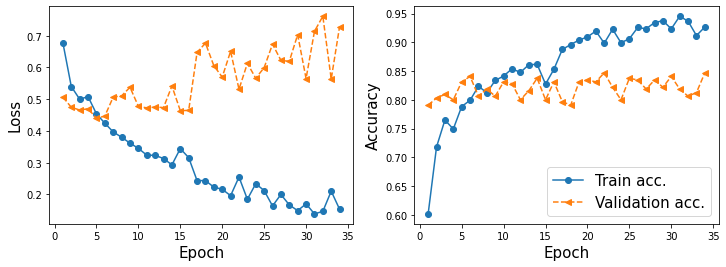

In [25]:
import matplotlib.pyplot as plt

history = hist.history
x_arr = np.arange(len(history['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, history['loss'], '-o', label='Train loss')
ax.plot(x_arr, history['val_loss'], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, history['binary_accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, history['val_binary_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

In [26]:
model.save('models/umberto_feedforward')
! cp -r models ./drive/My\ Drive/Colab\ Notebooks/

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/aaaumberto_feedforward/assets


In [27]:
import pickle
import os

pickle.dump(X_train,
            open(os.path.join('X_train.pkl'), 'wb'),
            protocol=4)
pickle.dump(X_test,
            open(os.path.join('X_test.pkl'), 'wb'),
            protocol=4)
pickle.dump(y_train,
            open(os.path.join('y_train.pkl'), 'wb'),
            protocol=4)
pickle.dump(y_test,
            open(os.path.join('y_test.pkl'), 'wb'),
            protocol=4)

In [28]:
! cp *.pkl ./drive/My\ Drive/Colab\ Notebooks/